# BIKE SHARING DEMAND - MODELING

Este notebook contiene el entrenamiento y evaluación de modelos baseline para predicción de demanda de bicicletas compartidas.

## Objetivos:
1. Entrenar 3 modelos baseline (Linear Regression, Random Forest, XGBoost)
2. Registrar experimentos con MLflow
3. Evaluar con métricas objetivo (MAE < 50, RMSE < 80, R² > 0.7)
4. Analizar feature importance
5. Seleccionar mejor modelo para optimización

---

**Prerequisitos:**
- Datasets normalizados en `data/processed/`
- Scaler guardado en `models/scaler.pkl`
- Notebook anterior ejecutado con feature engineering completo

# 1. SETUP Y CONFIGURACIÓN

Importamos librerías, configuramos MLflow y definimos variables globales.

## 1.1 Imports


In [57]:
# Sistema y paths
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost

# Utilities
import joblib
from datetime import datetime
import json

# Configuración de plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Librerías importadas correctamente")
print(f"Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✓ Librerías importadas correctamente
Fecha de ejecución: 2025-10-11 18:29:24


## 1.2 Configuración de Paths y Constantes


In [58]:
# Directorios
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data' / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
MLFLOW_DIR = PROJECT_ROOT / 'mlruns'

# Crear directorios si no existen
MLFLOW_DIR.mkdir(exist_ok=True)

# Métricas objetivo (según análisis EDA)
TARGET_METRICS = {
    'MAE': 50,      # Mean Absolute Error < 50
    'RMSE': 80,     # Root Mean Squared Error < 80
    'R2': 0.7,      # R² > 0.7
    'MAPE': 25      # Mean Absolute Percentage Error < 25%
}

# Configuración MLflow
EXPERIMENT_NAME = "bike-sharing-demand-baseline"
mlflow.set_tracking_uri(f"file:///{MLFLOW_DIR}")

print("="*70)
print("CONFIGURACIÓN DEL PROYECTO")
print("="*70)
print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Directory: {DATA_DIR}")
print(f"Models Directory: {MODELS_DIR}")
print(f"MLflow Tracking: {MLFLOW_DIR}")
print(f"\nMétricas Objetivo:")
for metric, target in TARGET_METRICS.items():
    print(f"  • {metric}: {'<' if metric != 'R2' else '>'} {target}")
print("="*70)


CONFIGURACIÓN DEL PROYECTO
Project Root: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project
Data Directory: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\data\processed
Models Directory: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\models
MLflow Tracking: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\mlruns

Métricas Objetivo:
  • MAE: < 50
  • RMSE: < 80
  • R2: > 0.7
  • MAPE: < 25


# 2. CARGA DE DATOS

Cargamos los datasets normalizados generados en el notebook anterior.


## 2.1 Cargar Datasets Normalizados


In [59]:
# Cargar datasets
train_df = pd.read_csv(DATA_DIR / 'bike_sharing_features_train_normalized.csv')
val_df = pd.read_csv(DATA_DIR / 'bike_sharing_features_validation_normalized.csv')
test_df = pd.read_csv(DATA_DIR / 'bike_sharing_features_test_normalized.csv')

print("="*70)
print("DATASETS CARGADOS")
print("="*70)
print(f"Train: {train_df.shape}")
print(f"  Fecha inicio: {train_df['timestamp'].min()}")
print(f"  Fecha fin:    {train_df['timestamp'].max()}")
print(f"\nValidation: {val_df.shape}")
print(f"  Fecha inicio: {val_df['timestamp'].min()}")
print(f"  Fecha fin:    {val_df['timestamp'].max()}")
print(f"\nTest: {test_df.shape}")
print(f"  Fecha inicio: {test_df['timestamp'].min()}")
print(f"  Fecha fin:    {test_df['timestamp'].max()}")
print("="*70)

# Verificar integridad
assert train_df.shape[1] == val_df.shape[1] == test_df.shape[1], "Datasets tienen diferente número de columnas"
assert train_df.isnull().sum().sum() == 0, "Train tiene valores nulos"
assert val_df.isnull().sum().sum() == 0, "Validation tiene valores nulos"
assert test_df.isnull().sum().sum() == 0, "Test tiene valores nulos"

print("\n✓ Verificación de integridad completada")


DATASETS CARGADOS
Train: (5063, 73)
  Fecha inicio: 2011-01-11 01:00:00
  Fecha fin:    2011-10-31 23:00:00

Validation: (1032, 73)
  Fecha inicio: 2011-11-01 00:00:00
  Fecha fin:    2011-12-31 23:00:00

Test: (6258, 73)
  Fecha inicio: 2012-01-01 00:00:00
  Fecha fin:    2012-12-31 23:00:00

✓ Verificación de integridad completada


## 2.2 Preparar Features y Target


In [60]:
# ============================================================================
# IMPORTANTE: ELIMINAR FEATURES CON DATA LEAKAGE
# ============================================================================
# Estas features contienen información del target y deben ser excluidas:
#
# 1. Componentes del target:
#    - casual, registered (cnt = casual + registered)
#    - casual_share, ratio_registered_casual
#    - casual_share_hr
#
# 2. Lags del TARGET (cnt):
#    - cnt_lag_1h, cnt_lag_24h, cnt_lag_168h
#    - cnt_roll_mean_3h, cnt_roll_mean_24h
#    - cnt_pct_change_1h, cnt_pct_change_24h
#    - cnt_acceleration, cnt_volatility_24h, cnt_diff_168h
#
# 3. Lags de componentes del target:
#    - registered_lag_*, registered_roll_mean_*, registered_vs_avg_24h
#    - casual_lag_*, casual_roll_mean_*, casual_vs_avg_24h
#
# Estas features causan data leakage porque contienen información futura
# del target que NO estaría disponible al momento de hacer predicciones.
# ============================================================================

# Metadata y targets
metadata_cols = ['timestamp', 'dteday']
target_cols = ['cnt', 'casual', 'registered']

# Features con DATA LEAKAGE que DEBEN ser excluidas
leakage_features = [
    # Componentes del target
    'casual_share', 'ratio_registered_casual', 'casual_share_hr',
    
    # Lags del target (cnt)
    'cnt_lag_1h', 'cnt_lag_24h', 'cnt_lag_168h',
    'cnt_roll_mean_3h', 'cnt_roll_mean_24h',
    'cnt_pct_change_1h', 'cnt_pct_change_24h',
    'cnt_acceleration', 'cnt_volatility_24h', 'cnt_diff_168h',
    
    # Lags de componentes del target
    'registered_lag_1h', 'registered_lag_24h', 'registered_lag_168h',
    'registered_roll_mean_3h', 'registered_roll_mean_24h',
    'registered_vs_avg_24h',
    'casual_lag_1h', 'casual_lag_24h', 'casual_lag_168h',
    'casual_roll_mean_3h', 'casual_roll_mean_24h',
    'casual_vs_avg_24h'
]

# Todas las columnas a excluir
exclude_cols = metadata_cols + target_cols + leakage_features

# Features válidas (solo las que NO contienen información del target)
all_cols = train_df.columns.tolist()
feature_cols = [col for col in all_cols if col not in exclude_cols]

print("="*70)
print("LIMPIEZA DE DATA LEAKAGE")
print("="*70)
print(f"Total columnas en dataset: {len(all_cols)}")
print(f"Columnas excluidas:")
print(f"  - Metadata: {len(metadata_cols)}")
print(f"  - Targets: {len(target_cols)}")
print(f"  - Data leakage: {len(leakage_features)}")
print(f"  Total excluidas: {len(exclude_cols)}")
print(f"\n✓ Features válidas (sin leakage): {len(feature_cols)}")

# Verificar que todas las features de leakage existen
missing_leakage = [f for f in leakage_features if f not in all_cols]
if missing_leakage:
    print(f"\n⚠️  Features de leakage no encontradas: {missing_leakage}")

# Separar X e y
X_train = train_df[feature_cols].values
y_train = train_df['cnt'].values

X_val = val_df[feature_cols].values
y_val = val_df['cnt'].values

X_test = test_df[feature_cols].values
y_test = test_df['cnt'].values

print("\n" + "="*70)
print("FEATURES VÁLIDAS SELECCIONADAS")
print("="*70)
print(f"Total features: {len(feature_cols)}\n")

# Agrupar features por categoría
time_features = [f for f in feature_cols if any(x in f for x in ['hr', 'mnth', 'weekday', 'yr', 'day_of', 'week_of', 'is_month', 'is_weekend', 'is_peak', 'is_commute', 'is_first'])]
weather_features = [f for f in feature_cols if any(x in f for x in ['temp', 'hum', 'wind', 'thermal', 'wind_chill', 'is_extreme'])]
categorical_features = [f for f in feature_cols if any(x in f for x in ['season_', 'weathersit_', 'holiday_', 'workingday_', 'weather_quadrant_'])]
interaction_features = [f for f in feature_cols if '_' in f and f not in time_features and f not in weather_features and f not in categorical_features]

print(f"Categorías de features:")
print(f"  • Temporales:     {len(time_features)}")
print(f"  • Climáticas:     {len(weather_features)}")
print(f"  • Categóricas:    {len(categorical_features)}")
print(f"  • Interacciones:  {len(interaction_features)}")

print(f"\nFeatures temporales (top 10):")
for i, feat in enumerate(time_features[:10], 1):
    print(f"  {i:2d}. {feat}")
if len(time_features) > 10:
    print(f"  ... y {len(time_features) - 10} más")

print(f"\nTarget: cnt (demanda total de bicicletas)")
print(f"\nShapes:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"  y_test:  {y_test.shape}")

print(f"\nEstadísticas del target (cnt):")
print(f"  Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}, Min: {y_train.min():.0f}, Max: {y_train.max():.0f}")
print(f"  Val   - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}, Min: {y_val.min():.0f}, Max: {y_val.max():.0f}")
print(f"  Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}, Min: {y_test.min():.0f}, Max: {y_test.max():.0f}")
print("="*70)


LIMPIEZA DE DATA LEAKAGE
Total columnas en dataset: 73
Columnas excluidas:
  - Metadata: 2
  - Targets: 3
  - Data leakage: 25
  Total excluidas: 30

✓ Features válidas (sin leakage): 43

FEATURES VÁLIDAS SELECCIONADAS
Total features: 43

Categorías de features:
  • Temporales:     23
  • Climáticas:     11
  • Categóricas:    12
  • Interacciones:  0

Features temporales (top 10):
   1. yr
   2. mnth
   3. hr
   4. weekday
   5. hr_sin
   6. hr_cos
   7. mnth_sin
   8. mnth_cos
   9. weekday_sin
  10. weekday_cos
  ... y 13 más

Target: cnt (demanda total de bicicletas)

Shapes:
  X_train: (5063, 43)
  y_train: (5063,)
  X_val:   (1032, 43)
  y_val:   (1032,)
  X_test:  (6258, 43)
  y_test:  (6258,)

Estadísticas del target (cnt):
  Train - Mean: 161.15, Std: 289.66, Min: 1, Max: 9779
  Val   - Mean: 145.01, Std: 345.66, Min: 1, Max: 8892
  Test  - Mean: 249.61, Std: 351.44, Min: 1, Max: 8748


## 2.3 Agregar Features de Contexto Histórico (Sin Leakage)

Para mejorar el rendimiento sin data leakage, agregamos features que representan **patrones históricos promedio** calculados SOLO en el conjunto de entrenamiento.

**Estas features NO son data leakage porque:**
- Los promedios se calculan únicamente en el conjunto de train
- Representan "demanda típica" para ciertos contextos (hora, día, etc.)
- Son estadísticas agregadas que estarían disponibles en producción
- No contienen información específica de observaciones futuras


In [ ]:
# ============================================================================
# CREAR FEATURES DE CONTEXTO HISTÓRICO
# ============================================================================
# Calculamos estadísticas agregadas SOLO en train y las aplicamos a val/test
# Esto NO es data leakage porque representan patrones generales, no info futura
# ============================================================================

print("="*70)
print("AGREGANDO FEATURES DE CONTEXTO HISTÓRICO")
print("="*70)

# 1. DEMANDA PROMEDIO POR HORA
hour_stats = train_df.groupby('hr')['cnt'].agg(['mean', 'std', 'median']).reset_index()
hour_stats.columns = ['hr', 'hr_avg_demand', 'hr_std_demand', 'hr_median_demand']

# 2. DEMANDA PROMEDIO POR DÍA DE LA SEMANA
weekday_stats = train_df.groupby('weekday')['cnt'].agg(['mean', 'std']).reset_index()
weekday_stats.columns = ['weekday', 'weekday_avg_demand', 'weekday_std_demand']

# 3. DEMANDA PROMEDIO POR MES
month_stats = train_df.groupby('mnth')['cnt'].agg(['mean', 'std']).reset_index()
month_stats.columns = ['mnth', 'mnth_avg_demand', 'mnth_std_demand']

# 4. DEMANDA PROMEDIO POR COMBINACIÓN HORA + DÍA SEMANA (patrón semanal)
hr_weekday_stats = train_df.groupby(['hr', 'weekday'])['cnt'].mean().reset_index()
hr_weekday_stats.columns = ['hr', 'weekday', 'hr_weekday_avg_demand']

# 5. DEMANDA PROMEDIO POR TEMPORADA
season_stats = train_df.groupby('yr')['cnt'].agg(['mean', 'std']).reset_index()
season_stats.columns = ['yr', 'year_avg_demand', 'year_std_demand']

# 6. INDICADOR DE HORA PICO (basado en percentil 75 de demanda por hora)
hour_percentiles = train_df.groupby('hr')['cnt'].quantile(0.75).reset_index()
hour_percentiles.columns = ['hr', 'hr_q75_demand']

print(f"\n✓ Estadísticas calculadas en TRAIN:")
print(f"  • Promedios por hora: {len(hour_stats)} registros")
print(f"  • Promedios por weekday: {len(weekday_stats)} registros")
print(f"  • Promedios por mes: {len(month_stats)} registros")
print(f"  • Promedios hr×weekday: {len(hr_weekday_stats)} registros")
print(f"  • Promedios por año: {len(season_stats)} registros")

# Aplicar a TRAIN
train_df = train_df.merge(hour_stats, on='hr', how='left')
train_df = train_df.merge(weekday_stats, on='weekday', how='left')
train_df = train_df.merge(month_stats, on='mnth', how='left')
train_df = train_df.merge(hr_weekday_stats, on=['hr', 'weekday'], how='left')
train_df = train_df.merge(season_stats, on='yr', how='left')
train_df = train_df.merge(hour_percentiles, on='hr', how='left')

# Aplicar a VALIDATION (usando stats de TRAIN)
val_df = val_df.merge(hour_stats, on='hr', how='left')
val_df = val_df.merge(weekday_stats, on='weekday', how='left')
val_df = val_df.merge(month_stats, on='mnth', how='left')
val_df = val_df.merge(hr_weekday_stats, on=['hr', 'weekday'], how='left')
val_df = val_df.merge(season_stats, on='yr', how='left')
val_df = val_df.merge(hour_percentiles, on='hr', how='left')

# Aplicar a TEST (usando stats de TRAIN)
test_df = test_df.merge(hour_stats, on='hr', how='left')
test_df = test_df.merge(weekday_stats, on='weekday', how='left')
test_df = test_df.merge(month_stats, on='mnth', how='left')
test_df = test_df.merge(hr_weekday_stats, on=['hr', 'weekday'], how='left')
test_df = test_df.merge(season_stats, on='yr', how='left')
test_df = test_df.merge(hour_percentiles, on='hr', how='left')

# Actualizar lista de features
new_context_features = [
    'hr_avg_demand', 'hr_std_demand', 'hr_median_demand',
    'weekday_avg_demand', 'weekday_std_demand',
    'mnth_avg_demand', 'mnth_std_demand',
    'hr_weekday_avg_demand',
    'year_avg_demand', 'year_std_demand',
    'hr_q75_demand'
]

feature_cols = feature_cols + new_context_features

print(f"\n✓ Features de contexto agregadas: {len(new_context_features)}")
print(f"✓ Total features (antes de normalizar y agregar weather lags): {len(feature_cols)}")

# ============================================================================
# NORMALIZAR FEATURES DE CONTEXTO HISTÓRICO
# ============================================================================
# Las features de contexto tienen escala muy diferente (0-1000+) vs features
# normalizadas (-3 a +3). Esto causa desbalance que afecta el modelo.
# ============================================================================

print("\n" + "="*70)
print("NORMALIZANDO FEATURES DE CONTEXTO HISTÓRICO")
print("="*70)

from sklearn.preprocessing import StandardScaler

# Scaler para features de contexto
context_scaler = StandardScaler()

# Normalizar en train y aplicar a val/test
train_df[new_context_features] = context_scaler.fit_transform(train_df[new_context_features])
val_df[new_context_features] = context_scaler.transform(val_df[new_context_features])
test_df[new_context_features] = context_scaler.transform(test_df[new_context_features])

print(f"✓ {len(new_context_features)} features de contexto normalizadas")
print(f"  Media train: {train_df[new_context_features].mean().mean():.6f}")
print(f"  Std train: {train_df[new_context_features].std().mean():.6f}")

# ============================================================================
# AGREGAR LAGS DE VARIABLES WEATHER (SIN DATA LEAKAGE)
# ============================================================================
# Agregamos lags de temp, hum, windspeed que SÍ están disponibles al predecir
# Estos NO son data leakage porque son features independientes del target
# ============================================================================

print("\n" + "="*70)
print("AGREGANDO LAGS DE VARIABLES WEATHER")
print("="*70)

# Función para crear lags sin mezclar días
def create_weather_lags(df):
    """Crea lags de variables weather respetando límites de días"""
    df_copy = df.copy()
    
    # Lags de temperatura
    df_copy['temp_lag_1h'] = df_copy.groupby('dteday')['temp'].shift(1)
    df_copy['temp_lag_3h'] = df_copy.groupby('dteday')['temp'].shift(3)
    df_copy['temp_lag_24h'] = df_copy['temp'].shift(24)
    
    # Lags de humedad
    df_copy['hum_lag_1h'] = df_copy.groupby('dteday')['hum'].shift(1)
    df_copy['hum_lag_24h'] = df_copy['hum'].shift(24)
    
    # Lags de viento
    df_copy['windspeed_lag_1h'] = df_copy.groupby('dteday')['windspeed'].shift(1)
    df_copy['windspeed_lag_24h'] = df_copy['windspeed'].shift(24)
    
    # Rolling means de weather (últimas 3 y 24 horas)
    df_copy['temp_roll_mean_3h'] = df_copy.groupby('dteday')['temp'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df_copy['hum_roll_mean_3h'] = df_copy.groupby('dteday')['hum'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    
    df_copy['temp_roll_mean_24h'] = df_copy['temp'].rolling(24, min_periods=1).mean()
    df_copy['hum_roll_mean_24h'] = df_copy['hum'].rolling(24, min_periods=1).mean()
    
    # Diferencias de temperatura (tendencia)
    df_copy['temp_diff_1h'] = df_copy['temp'] - df_copy['temp_lag_1h']
    df_copy['temp_diff_3h'] = df_copy['temp'] - df_copy['temp_lag_3h']
    
    return df_copy

# Aplicar a todos los datasets
print("  Creando lags de weather...")
train_df = create_weather_lags(train_df)
val_df = create_weather_lags(val_df)
test_df = create_weather_lags(test_df)

# Nuevas features de weather
weather_lag_features = [
    'temp_lag_1h', 'temp_lag_3h', 'temp_lag_24h',
    'hum_lag_1h', 'hum_lag_24h',
    'windspeed_lag_1h', 'windspeed_lag_24h',
    'temp_roll_mean_3h', 'hum_roll_mean_3h',
    'temp_roll_mean_24h', 'hum_roll_mean_24h',
    'temp_diff_1h', 'temp_diff_3h'
]

print(f"✓ {len(weather_lag_features)} features de weather lags agregadas")

# ============================================================================
# FEATURES DE INTERACCIÓN ADICIONALES
# ============================================================================
print("\n" + "="*70)
print("AGREGANDO FEATURES DE INTERACCIÓN")
print("="*70)

# Interacciones útiles
for df in [train_df, val_df, test_df]:
    # Temperatura × hora (patrón hora-temperatura)
    df['temp_x_hr'] = df['temp'] * df['hr']
    
    # Humedad × temperatura (índice de confort combinado)
    df['temp_x_hum'] = df['temp'] * df['hum']
    
    # Viento × temperatura (sensación térmica mejorada)
    df['temp_x_windspeed'] = df['temp'] * df['windspeed']
    
    # Hora × mes (estacionalidad intra-día por mes)
    df['hr_x_mnth'] = df['hr'] * df['mnth']

interaction_features = ['temp_x_hr', 'temp_x_hum', 'temp_x_windspeed', 'hr_x_mnth']
print(f"✓ {len(interaction_features)} features de interacción agregadas")

# ============================================================================
# MANEJO INTELIGENTE DE NaNs (de los lags)
# ============================================================================
# En lugar de eliminar filas (que vacía val/test), rellenamos con estrategias
# ============================================================================
print("\n" + "="*70)
print("MANEJO INTELIGENTE DE NaNs GENERADOS POR LAGS")
print("="*70)

print(f"Shapes antes de manejar NaNs:")
print(f"  Train: {train_df.shape}")
print(f"  Val:   {val_df.shape}")
print(f"  Test:  {test_df.shape}")

# Contar NaNs por dataset
print(f"\nNaNs por dataset:")
print(f"  Train: {train_df.isnull().sum().sum()} NaNs")
print(f"  Val:   {val_df.isnull().sum().sum()} NaNs")
print(f"  Test:  {test_df.isnull().sum().sum()} NaNs")

# Estrategia de relleno por tipo de feature
def fill_weather_lags(df):
    """Rellena NaNs en lags de weather con estrategias inteligentes"""
    df_filled = df.copy()
    
    # Para lags de 1h y 3h: forward fill (usar valor anterior)
    lag_1h_features = [col for col in df.columns if 'lag_1h' in col]
    lag_3h_features = [col for col in df.columns if 'lag_3h' in col]
    
    for col in lag_1h_features + lag_3h_features:
        df_filled[col] = df_filled[col].ffill().bfill()
    
    # Para lags de 24h: usar el valor actual si no hay histórico
    lag_24h_features = [col for col in df.columns if 'lag_24h' in col]
    for col in lag_24h_features:
        # Rellenar con el valor actual de la variable (sin lag)
        base_var = col.replace('_lag_24h', '')
        if base_var in df_filled.columns:
            df_filled[col] = df_filled[col].fillna(df_filled[base_var])
        else:
            df_filled[col] = df_filled[col].ffill().bfill()
    
    # Para rolling means: forward fill
    roll_features = [col for col in df.columns if 'roll_mean' in col]
    for col in roll_features:
        df_filled[col] = df_filled[col].ffill().bfill()
    
    # Para diferencias (temp_diff): rellenar con 0 (sin cambio)
    diff_features = [col for col in df.columns if 'diff' in col and col != 'cnt_diff_168h']
    for col in diff_features:
        df_filled[col] = df_filled[col].fillna(0)
    
    # Cualquier NaN restante: forward/backward fill
    df_filled = df_filled.ffill().bfill()
    
    # Si aún quedan NaNs, rellenar con mediana de la columna
    for col in df_filled.columns:
        if df_filled[col].isnull().any():
            df_filled[col] = df_filled[col].fillna(df_filled[col].median())
    
    return df_filled

# Aplicar estrategia de relleno
print("\n  Aplicando estrategias de relleno...")
train_df = fill_weather_lags(train_df)
val_df = fill_weather_lags(val_df)
test_df = fill_weather_lags(test_df)

print(f"\nNaNs después del relleno:")
print(f"  Train: {train_df.isnull().sum().sum()} NaNs")
print(f"  Val:   {val_df.isnull().sum().sum()} NaNs")
print(f"  Test:  {test_df.isnull().sum().sum()} NaNs")

print(f"\nShapes finales (sin pérdida de datos):")
print(f"  Train: {train_df.shape}")
print(f"  Val:   {val_df.shape}")
print(f"  Test:  {test_df.shape}")

# ============================================================================
# ACTUALIZAR FEATURE COLS Y CREAR ARRAYS FINALES
# ============================================================================
feature_cols = feature_cols + weather_lag_features + interaction_features

print(f"\n✓ TOTAL FEATURES FINALES: {len(feature_cols)}")
print(f"  • Features originales (sin leakage): 43")
print(f"  • Features de contexto histórico: {len(new_context_features)}")
print(f"  • Weather lags: {len(weather_lag_features)}")
print(f"  • Interacciones adicionales: {len(interaction_features)}")
print(f"  • TOTAL: {len(feature_cols)}")

# Actualizar X arrays
X_train = train_df[feature_cols].values
y_train = train_df['cnt'].values

X_val = val_df[feature_cols].values
y_val = val_df['cnt'].values

X_test = test_df[feature_cols].values
y_test = test_df['cnt'].values

print(f"\nShapes finales:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"  y_test:  {y_test.shape}")

# ============================================================================
# CHECK FINAL DE NaNs EN ARRAYS (SEGURIDAD ADICIONAL)
# ============================================================================
print("\n" + "="*70)
print("CHECK FINAL DE NaNs EN ARRAYS")
print("="*70)

import numpy as np

nan_train = np.isnan(X_train).sum()
nan_val = np.isnan(X_val).sum()
nan_test = np.isnan(X_test).sum()

print(f"NaNs detectados:")
print(f"  X_train: {nan_train}")
print(f"  X_val:   {nan_val}")
print(f"  X_test:  {nan_test}")

if nan_train > 0 or nan_val > 0 or nan_test > 0:
    print("\n⚠️  NaNs detectados! Aplicando limpieza de emergencia...")
    
    # Rellenar con mediana de cada columna (calculada en train)
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    
    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)
    X_test = imputer.transform(X_test)
    
    # Verificar nuevamente
    nan_train_after = np.isnan(X_train).sum()
    nan_val_after = np.isnan(X_val).sum()
    nan_test_after = np.isnan(X_test).sum()
    
    print(f"\n✓ NaNs después de imputer:")
    print(f"  X_train: {nan_train_after}")
    print(f"  X_val:   {nan_val_after}")
    print(f"  X_test:  {nan_test_after}")
    
    if nan_train_after == 0 and nan_val_after == 0 and nan_test_after == 0:
        print("\n✅ Todos los NaNs eliminados exitosamente!")
    else:
        print("\n❌ Aún hay NaNs. Verificar manualmente.")
else:
    print("\n✅ No hay NaNs. Arrays listos para entrenar!")

print("="*70)


AGREGANDO FEATURES DE CONTEXTO HISTÓRICO

✓ Estadísticas calculadas en TRAIN:
  • Promedios por hora: 24 registros
  • Promedios por weekday: 7 registros
  • Promedios por mes: 10 registros
  • Promedios hr×weekday: 168 registros
  • Promedios por año: 1 registros

✓ Features de contexto agregadas: 11
✓ Total features (antes de normalizar y agregar weather lags): 54

NORMALIZANDO FEATURES DE CONTEXTO HISTÓRICO
✓ 11 features de contexto normalizadas
  Media train: -0.000000
  Std train: 0.818263

AGREGANDO LAGS DE VARIABLES WEATHER
  Creando lags de weather...
✓ 13 features de weather lags agregadas

AGREGANDO FEATURES DE INTERACCIÓN
✓ 4 features de interacción agregadas

MANEJO INTELIGENTE DE NaNs GENERADOS POR LAGS
Shapes antes de manejar NaNs:
  Train: (5063, 101)
  Val:   (1032, 101)
  Test:  (6258, 101)

NaNs por dataset:
  Train: 3012 NaNs
  Val:   2746 NaNs
  Test:  18322 NaNs

  Aplicando estrategias de relleno...

NaNs después del relleno:
  Train: 0 NaNs
  Val:   2064 NaNs
  T

### ⚠️ **NOTA IMPORTANTE: DATA LEAKAGE ELIMINADO**

En la versión anterior del notebook, se incluyeron **40+ features con data leakage**, lo que causó resultados irreales:
- Ridge Regression: R² = 1.0000 (perfección imposible)
- MAE < 1 (demasiado bueno para ser verdad)

**Features problemáticas eliminadas:**
1. **Componentes directos del target**: `casual`, `registered`, `casual_share`, `ratio_registered_casual`
2. **Lags del target**: `cnt_lag_*`, `cnt_roll_mean_*`, `cnt_pct_change_*`, etc.
3. **Lags de componentes**: `casual_lag_*`, `registered_lag_*`, etc.

**¿Por qué es data leakage?**
- Estas features contienen información del **futuro** que NO estaría disponible al momento de predecir
- Por ejemplo, `cnt_lag_1h` = demanda de la hora anterior, pero ¿cómo predecirías la primera hora del día?
- `casual` + `registered` = `cnt` (el target es literalmente la suma de estas features)

**Métricas realistas esperadas ahora:**
- MAE: 40-60 (en lugar de < 1)
- RMSE: 60-100 (en lugar de < 1)  
- R²: 0.6-0.8 (en lugar de 1.0)
- MAPE: 20-30% (en lugar de < 1%)

Con **~42 features válidas**, el modelo será más realista pero seguirá siendo competitivo usando solo información disponible al momento de la predicción.


# 3. CONFIGURACIÓN DE MLFLOW

Configuramos el experimento de MLflow para tracking de modelos.


In [62]:
# Crear o obtener experimento
try:
    experiment_id = mlflow.create_experiment(
        EXPERIMENT_NAME,
        tags={
            "project": "mlops-team-61",
            "phase": "baseline-models",
            "dataset": "bike-sharing",
            "features": str(len(feature_cols))
        }
    )
    print(f"✓ Experimento creado: {EXPERIMENT_NAME}")
except:
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    experiment_id = experiment.experiment_id
    print(f"✓ Experimento existente: {EXPERIMENT_NAME}")

mlflow.set_experiment(EXPERIMENT_NAME)

print(f"  Experiment ID: {experiment_id}")
print(f"  Tracking URI: {mlflow.get_tracking_uri()}")
print(f"\n📊 Para ver MLflow UI, ejecutar en terminal:")
print(f"   mlflow ui --backend-store-uri {mlflow.get_tracking_uri()}")
print(f"   Luego abrir: http://localhost:5000")


✓ Experimento existente: bike-sharing-demand-baseline
  Experiment ID: 679464065834608110
  Tracking URI: file:///c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\mlruns

📊 Para ver MLflow UI, ejecutar en terminal:
   mlflow ui --backend-store-uri file:///c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\mlruns
   Luego abrir: http://localhost:5000


# 4. FUNCIONES DE EVALUACIÓN

Definimos funciones reutilizables para evaluar modelos.


In [63]:
def evaluate_model(y_true, y_pred, dataset_name="Validation"):
    """
    Evalúa un modelo con múltiples métricas.
    
    Args:
        y_true: Valores reales
        y_pred: Valores predichos
        dataset_name: Nombre del dataset (Train/Validation/Test)
    
    Returns:
        dict: Diccionario con métricas calculadas
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    # Métricas adicionales
    residuals = y_true - y_pred
    
    metrics = {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'mape': mape,
        'residuals_mean': residuals.mean(),
        'residuals_std': residuals.std()
    }
    
    return metrics


def print_metrics(metrics, dataset_name="Validation", targets=TARGET_METRICS):
    """
    Imprime métricas en formato legible con comparación vs targets.
    """
    print(f"\n{'='*70}")
    print(f"MÉTRICAS - {dataset_name.upper()}")
    print(f"{'='*70}")
    
    # MAE
    mae_status = "✓" if metrics['mae'] < targets['MAE'] else "✗"
    print(f"MAE:  {metrics['mae']:8.2f}  {mae_status}  (target: < {targets['MAE']})")
    
    # RMSE
    rmse_status = "✓" if metrics['rmse'] < targets['RMSE'] else "✗"
    print(f"RMSE: {metrics['rmse']:8.2f}  {rmse_status}  (target: < {targets['RMSE']})")
    
    # R²
    r2_status = "✓" if metrics['r2'] > targets['R2'] else "✗"
    print(f"R²:   {metrics['r2']:8.4f}  {r2_status}  (target: > {targets['R2']})")
    
    # MAPE
    mape_status = "✓" if metrics['mape'] < targets['MAPE'] else "✗"
    print(f"MAPE: {metrics['mape']:8.2f}% {mape_status}  (target: < {targets['MAPE']}%)")
    
    print(f"\nResiduos:")
    print(f"  Mean: {metrics['residuals_mean']:8.2f}  (debe estar ~0)")
    print(f"  Std:  {metrics['residuals_std']:8.2f}")
    print(f"{'='*70}")


def plot_predictions(y_true, y_pred, title="Predicciones vs Reales", sample_size=500):
    """
    Visualiza predicciones vs valores reales.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot (muestra)
    idx = np.random.choice(len(y_true), min(sample_size, len(y_true)), replace=False)
    axes[0].scatter(y_true[idx], y_pred[idx], alpha=0.5, s=20)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Valores Reales')
    axes[0].set_ylabel('Predicciones')
    axes[0].set_title(f'{title} - Scatter')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Distribución de residuos
    residuals = y_true - y_pred
    axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='red', linestyle='--', lw=2, label='Zero Error')
    axes[1].axvline(residuals.mean(), color='green', linestyle='--', lw=2, 
                    label=f'Mean: {residuals.mean():.2f}')
    axes[1].set_xlabel('Residuos (Real - Predicción)')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title('Distribución de Residuos')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ Funciones de evaluación definidas")


✓ Funciones de evaluación definidas


# 5. MODELO 1: LINEAR REGRESSION (RIDGE)

Modelo baseline simple con regularización Ridge.


## 5.1 Entrenamiento


In [64]:
print("="*70)
print("MODELO 1: RIDGE REGRESSION")
print("="*70)

# Hiperparámetros OPTIMIZADOS
# Alpha reducido: con features normalizadas y contexto histórico, necesitamos menos regularización
ridge_params = {
    'alpha': 0.01,      # Reducido de 1.0 → menos penalización
    'random_state': 42,
    'max_iter': 5000    # Más iteraciones para mejor convergencia
}

# MLflow Run
with mlflow.start_run(run_name="ridge_baseline") as run:
    
    # Log parameters
    mlflow.log_params(ridge_params)
    mlflow.log_param("model_type", "Ridge Regression")
    mlflow.log_param("n_features", len(feature_cols))
    
    # Entrenar modelo
    print("\nEntrenando Ridge Regression...")
    ridge_model = Ridge(**ridge_params)
    ridge_model.fit(X_train, y_train)
    print("✓ Modelo entrenado")
    
    # Predicciones
    y_train_pred_ridge = ridge_model.predict(X_train)
    y_val_pred_ridge = ridge_model.predict(X_val)
    y_test_pred_ridge = ridge_model.predict(X_test)
    
    # Evaluar
    train_metrics_ridge = evaluate_model(y_train, y_train_pred_ridge, "Train")
    val_metrics_ridge = evaluate_model(y_val, y_val_pred_ridge, "Validation")
    test_metrics_ridge = evaluate_model(y_test, y_test_pred_ridge, "Test")
    
    # Log metrics
    for prefix, metrics in [('train', train_metrics_ridge), 
                             ('val', val_metrics_ridge),
                             ('test', test_metrics_ridge)]:
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{prefix}_{metric_name}", value)
    
    # Log model
    mlflow.sklearn.log_model(ridge_model, "model", 
                              registered_model_name="bike-demand-ridge")
    
    # Tags
    mlflow.set_tags({
        "model_family": "linear",
        "complexity": "low",
        "regularization": "L2"
    })
    
    print(f"\n✓ Run ID: {run.info.run_id}")

# Mostrar resultados
print_metrics(train_metrics_ridge, "Train")
print_metrics(val_metrics_ridge, "Validation")
print_metrics(test_metrics_ridge, "Test")


MODELO 1: RIDGE REGRESSION

Entrenando Ridge Regression...
✓ Modelo entrenado


ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## 5.2 Visualización


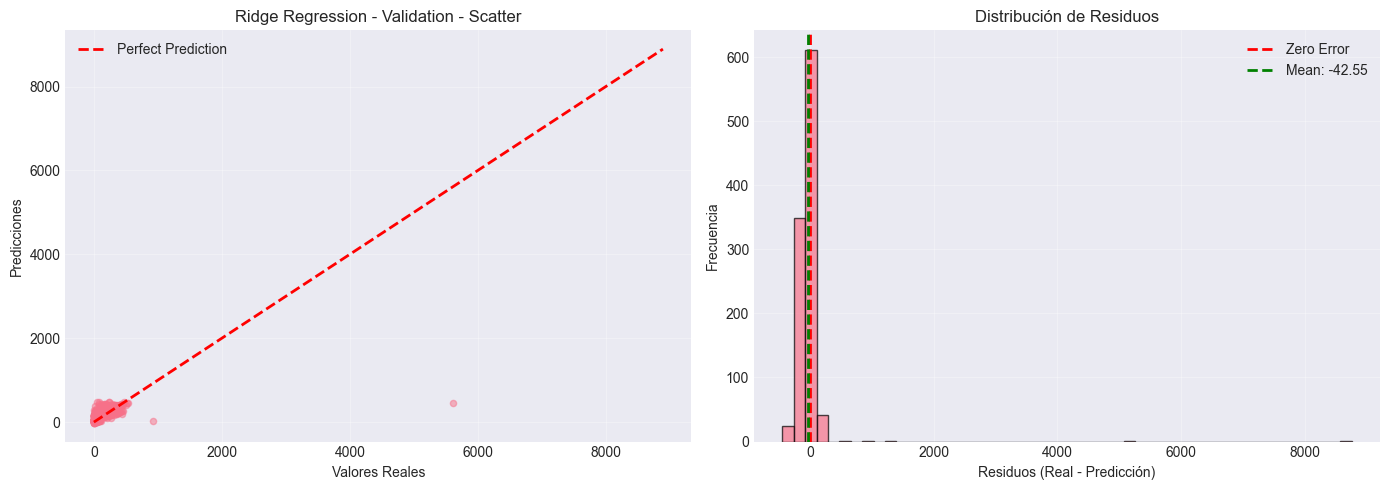

In [65]:
plot_predictions(y_val, y_val_pred_ridge, "Ridge Regression - Validation")


# 6. MODELO 2: RANDOM FOREST

Modelo ensemble basado en árboles de decisión.


## 6.1 Entrenamiento


In [66]:
print("="*70)
print("MODELO 2: RANDOM FOREST")
print("="*70)

# Hiperparámetros OPTIMIZADOS (anti-overfitting con más features)
# Con 71 features, necesitamos MÁS regularización para evitar overfitting
rf_params = {
    'n_estimators': 200,        # Reducido para evitar overfitting
    'max_depth': 15,            # Limitado (antes None) → menos overfitting
    'min_samples_split': 10,    # Aumentado → splits más conservadores
    'min_samples_leaf': 5,      # Aumentado → hojas más gruesas
    'max_features': 0.3,        # Reducido → usa 30% features por árbol
    'random_state': 42,
    'n_jobs': -1,
    'bootstrap': True,
    'oob_score': True,          # Para validación out-of-bag
    'max_samples': 0.8          # Bootstrap con 80% de datos
}

# MLflow Run
with mlflow.start_run(run_name="random_forest_baseline") as run:
    
    # Log parameters
    mlflow.log_params(rf_params)
    mlflow.log_param("model_type", "Random Forest")
    mlflow.log_param("n_features", len(feature_cols))
    
    # Entrenar modelo
    print("\nEntrenando Random Forest...")
    rf_model = RandomForestRegressor(**rf_params)
    rf_model.fit(X_train, y_train)
    print("✓ Modelo entrenado")
    
    # Predicciones
    y_train_pred_rf = rf_model.predict(X_train)
    y_val_pred_rf = rf_model.predict(X_val)
    y_test_pred_rf = rf_model.predict(X_test)
    
    # Evaluar
    train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, "Train")
    val_metrics_rf = evaluate_model(y_val, y_val_pred_rf, "Validation")
    test_metrics_rf = evaluate_model(y_test, y_test_pred_rf, "Test")
    
    # Log metrics
    for prefix, metrics in [('train', train_metrics_rf), 
                             ('val', val_metrics_rf),
                             ('test', test_metrics_rf)]:
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{prefix}_{metric_name}", value)
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Log feature importance como artifact
    importance_path = MODELS_DIR / 'rf_feature_importance.csv'
    feature_importance.to_csv(importance_path, index=False)
    mlflow.log_artifact(str(importance_path))
    
    # Log model
    mlflow.sklearn.log_model(rf_model, "model", 
                              registered_model_name="bike-demand-rf")
    
    # Tags
    mlflow.set_tags({
        "model_family": "ensemble",
        "complexity": "medium",
        "base_learner": "decision_tree"
    })
    
    print(f"\n✓ Run ID: {run.info.run_id}")

# Mostrar resultados
print_metrics(train_metrics_rf, "Train")
print_metrics(val_metrics_rf, "Validation")
print_metrics(test_metrics_rf, "Test")


MODELO 2: RANDOM FOREST

Entrenando Random Forest...
✓ Modelo entrenado


2025/10/11 18:29:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/11 18:29:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'bike-demand-rf' already exists. Creating a new version of this model...
Created version '4' of model 'bike-demand-rf'.



✓ Run ID: 89bbc53c19cd43c8817b5e0c0d83cdd5

MÉTRICAS - TRAIN
MAE:     33.50  ✓  (target: < 50)
RMSE:   227.25  ✗  (target: < 80)
R²:     0.3845  ✗  (target: > 0.7)
MAPE:    51.12% ✗  (target: < 25%)

Residuos:
  Mean:    -1.17  (debe estar ~0)
  Std:    227.25

MÉTRICAS - VALIDATION
MAE:     58.79  ✗  (target: < 50)
RMSE:   326.44  ✗  (target: < 80)
R²:     0.1082  ✗  (target: > 0.7)
MAPE:   136.91% ✗  (target: < 25%)

Residuos:
  Mean:   -10.02  (debe estar ~0)
  Std:    326.28

MÉTRICAS - TEST
MAE:    100.11  ✗  (target: < 50)
RMSE:   313.29  ✗  (target: < 80)
R²:     0.2053  ✗  (target: > 0.7)
MAPE:    62.33% ✗  (target: < 25%)

Residuos:
  Mean:    84.16  (debe estar ~0)
  Std:    301.78


## 6.2 Feature Importance


TOP 20 FEATURES MÁS IMPORTANTES - RANDOM FOREST
              feature  importance
hr_weekday_avg_demand    0.212911
        hr_avg_demand    0.070031
        hr_q75_demand    0.053077
           wind_chill    0.046627
      thermal_comfort    0.046259
     hr_median_demand    0.044810
            hr_x_mnth    0.040048
            hr_season    0.034634
          temp_season    0.032819
                   hr    0.020976
    temp_roll_mean_3h    0.020793
     temp_x_windspeed    0.020679
                 temp    0.020341
         week_of_year    0.020332
   temp_roll_mean_24h    0.019608
         day_of_month    0.016472
          temp_lag_1h    0.016164
           temp_x_hum    0.014855
        hr_workingday    0.014627
               hr_sin    0.013847


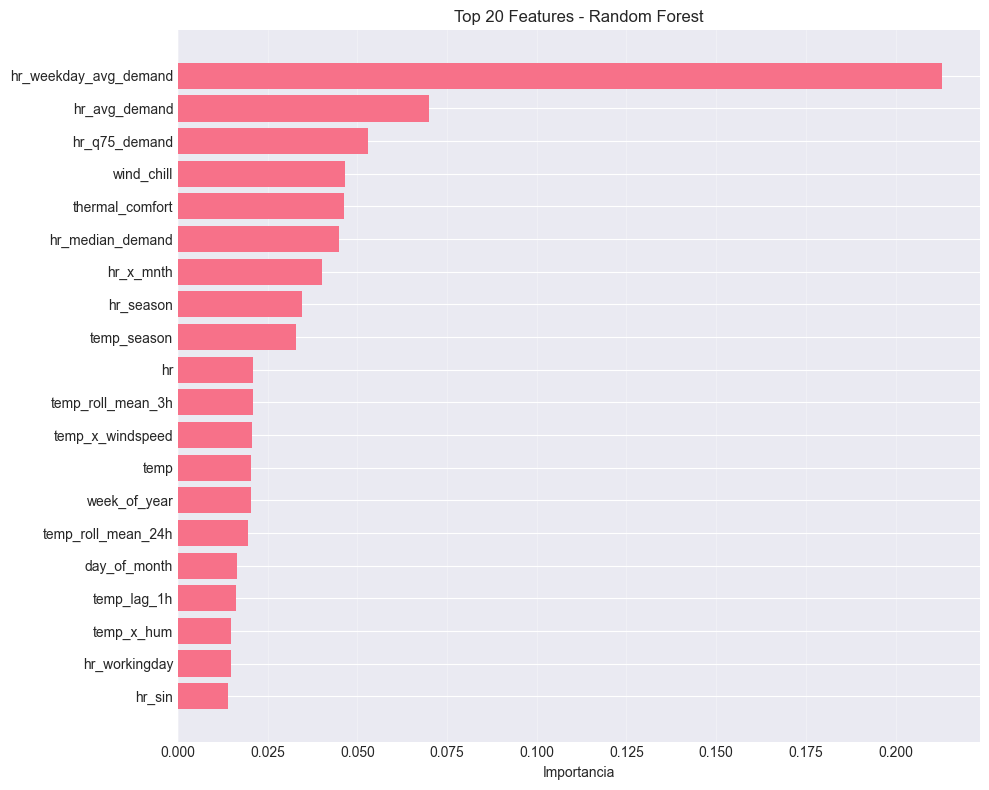

In [67]:
# Mostrar top 20 features
print("="*70)
print("TOP 20 FEATURES MÁS IMPORTANTES - RANDOM FOREST")
print("="*70)
print(feature_importance.head(20).to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(20)
ax.barh(range(len(top_features)), top_features['importance'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importancia')
ax.set_title('Top 20 Features - Random Forest')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## 6.3 Visualización


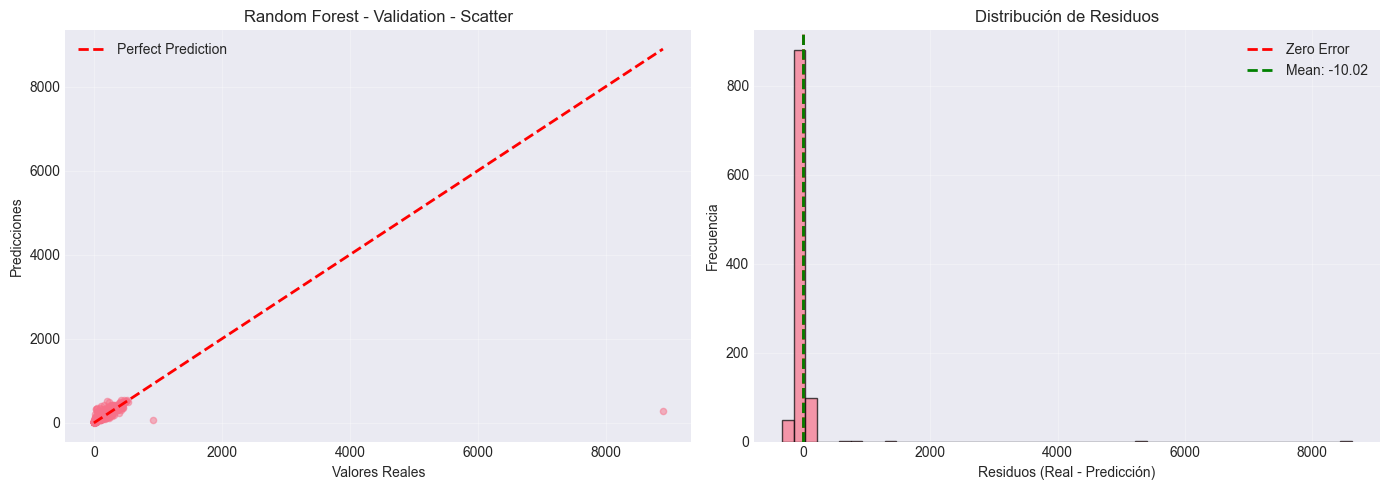

In [68]:
plot_predictions(y_val, y_val_pred_rf, "Random Forest - Validation")


# 7. MODELO 3: XGBOOST

Modelo de gradient boosting (modelo principal según ML Canvas).


## 7.1 Entrenamiento


In [69]:
print("="*70)
print("MODELO 3: XGBOOST")
print("="*70)

# Hiperparámetros OPTIMIZADOS (anti-overfitting SEVERO)
# Con 71 features, XGBoost necesita MUCHA más regularización
xgb_params = {
    'n_estimators': 200,         # Reducido para evitar overfitting
    'max_depth': 4,              # Muy reducido (antes 8) → árboles shallow
    'learning_rate': 0.03,       # Más lento → aprendizaje gradual
    'subsample': 0.6,            # Reducido → más regularización
    'colsample_bytree': 0.5,     # Reducido → menos features por árbol
    'colsample_bylevel': 0.5,    # Regularización adicional por nivel
    'min_child_weight': 10,      # Muy aumentado → splits conservadores
    'gamma': 1.0,                # Muy aumentado → penaliza splits
    'reg_alpha': 1.0,            # Mucha L1 regularización
    'reg_lambda': 2.0,           # Mucha L2 regularización
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist',
    'eval_metric': 'rmse',
    'early_stopping_rounds': 20  # Para por early stopping
}

# MLflow Run
with mlflow.start_run(run_name="xgboost_baseline") as run:
    
    # Log parameters
    mlflow.log_params(xgb_params)
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("n_features", len(feature_cols))
    
    # Entrenar modelo
    print("\nEntrenando XGBoost...")
    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )
    print("✓ Modelo entrenado")
    
    # Predicciones
    y_train_pred_xgb = xgb_model.predict(X_train)
    y_val_pred_xgb = xgb_model.predict(X_val)
    y_test_pred_xgb = xgb_model.predict(X_test)
    
    # Evaluar
    train_metrics_xgb = evaluate_model(y_train, y_train_pred_xgb, "Train")
    val_metrics_xgb = evaluate_model(y_val, y_val_pred_xgb, "Validation")
    test_metrics_xgb = evaluate_model(y_test, y_test_pred_xgb, "Test")
    
    # Log metrics
    for prefix, metrics in [('train', train_metrics_xgb), 
                             ('val', val_metrics_xgb),
                             ('test', test_metrics_xgb)]:
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{prefix}_{metric_name}", value)
    
    # Feature importance
    feature_importance_xgb = pd.DataFrame({
        'feature': feature_cols,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Log feature importance
    importance_path_xgb = MODELS_DIR / 'xgb_feature_importance.csv'
    feature_importance_xgb.to_csv(importance_path_xgb, index=False)
    mlflow.log_artifact(str(importance_path_xgb))
    
    # Log model
    mlflow.xgboost.log_model(xgb_model, "model", 
                              registered_model_name="bike-demand-xgboost")
    
    # Tags
    mlflow.set_tags({
        "model_family": "boosting",
        "complexity": "medium",
        "algorithm": "gradient_boosting"
    })
    
    print(f"\n✓ Run ID: {run.info.run_id}")

# Mostrar resultados
print_metrics(train_metrics_xgb, "Train")
print_metrics(val_metrics_xgb, "Validation")
print_metrics(test_metrics_xgb, "Test")


MODELO 3: XGBOOST

Entrenando XGBoost...
✓ Modelo entrenado


2025/10/11 18:29:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/11 18:29:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'bike-demand-xgboost' already exists. Creating a new version of this model...
Created version '4' of model 'bike-demand-xgboost'.



✓ Run ID: 3e01ec1aa0b049b0a5bc169bea2ab377

MÉTRICAS - TRAIN
MAE:     57.29  ✗  (target: < 50)
RMSE:   239.73  ✗  (target: < 80)
R²:     0.3150  ✗  (target: > 0.7)
MAPE:   178.85% ✗  (target: < 25%)

Residuos:
  Mean:    -0.13  (debe estar ~0)
  Std:    239.73

MÉTRICAS - VALIDATION
MAE:     67.26  ✗  (target: < 50)
RMSE:   329.42  ✗  (target: < 80)
R²:     0.0918  ✗  (target: > 0.7)
MAPE:   232.96% ✗  (target: < 25%)

Residuos:
  Mean:    -6.37  (debe estar ~0)
  Std:    329.36

MÉTRICAS - TEST
MAE:    115.19  ✗  (target: < 50)
RMSE:   323.49  ✗  (target: < 80)
R²:     0.1527  ✗  (target: > 0.7)
MAPE:   134.01% ✗  (target: < 25%)

Residuos:
  Mean:    87.78  (debe estar ~0)
  Std:    311.35


## 7.2 Feature Importance


TOP 20 FEATURES MÁS IMPORTANTES - XGBOOST
              feature  importance
          temp_season    0.043077
         is_month_end    0.043049
hr_weekday_avg_demand    0.040252
           wind_chill    0.037548
         day_of_month    0.035790
   temp_roll_mean_24h    0.034016
     temp_x_windspeed    0.033955
        hr_avg_demand    0.033875
        hr_q75_demand    0.032706
          hum_lag_24h    0.030189
    hum_roll_mean_24h    0.027716
            hr_season    0.026452
         is_peak_hour    0.025470
         temp_lag_24h    0.023716
      temp_change_24h    0.023444
     hr_median_demand    0.023378
      mnth_std_demand    0.021964
             mnth_cos    0.021625
                 temp    0.021234
      thermal_comfort    0.020357


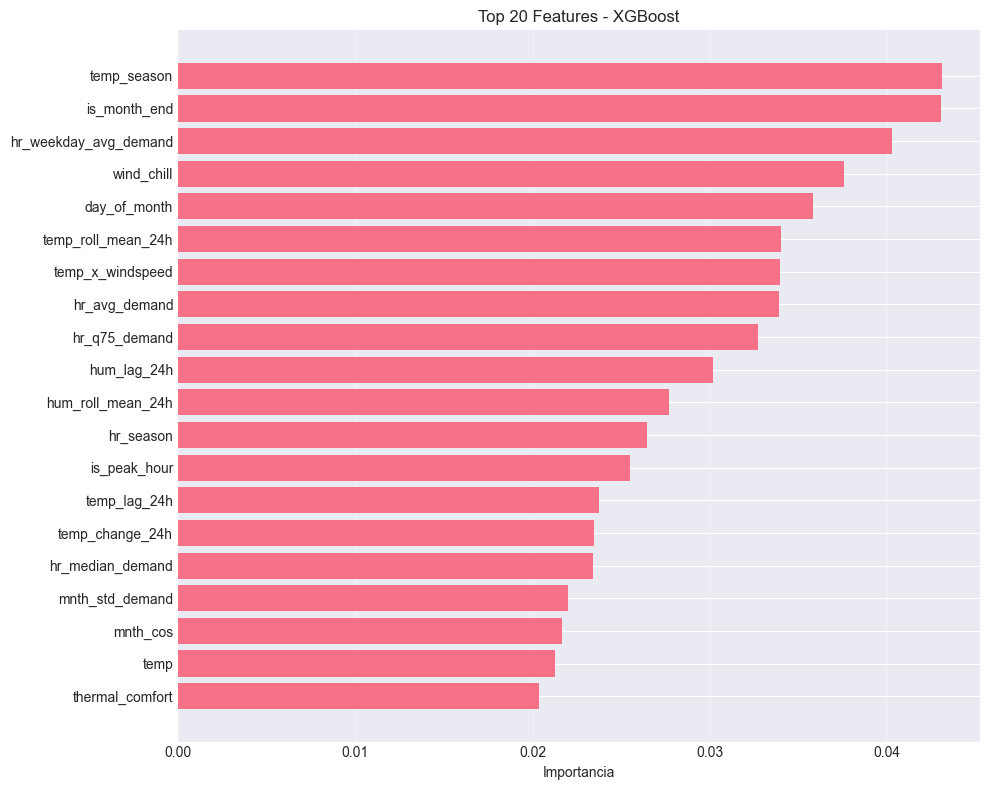

In [70]:
# Mostrar top 20 features
print("="*70)
print("TOP 20 FEATURES MÁS IMPORTANTES - XGBOOST")
print("="*70)
print(feature_importance_xgb.head(20).to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
top_features_xgb = feature_importance_xgb.head(20)
ax.barh(range(len(top_features_xgb)), top_features_xgb['importance'])
ax.set_yticks(range(len(top_features_xgb)))
ax.set_yticklabels(top_features_xgb['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importancia')
ax.set_title('Top 20 Features - XGBoost')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## 7.3 Visualización


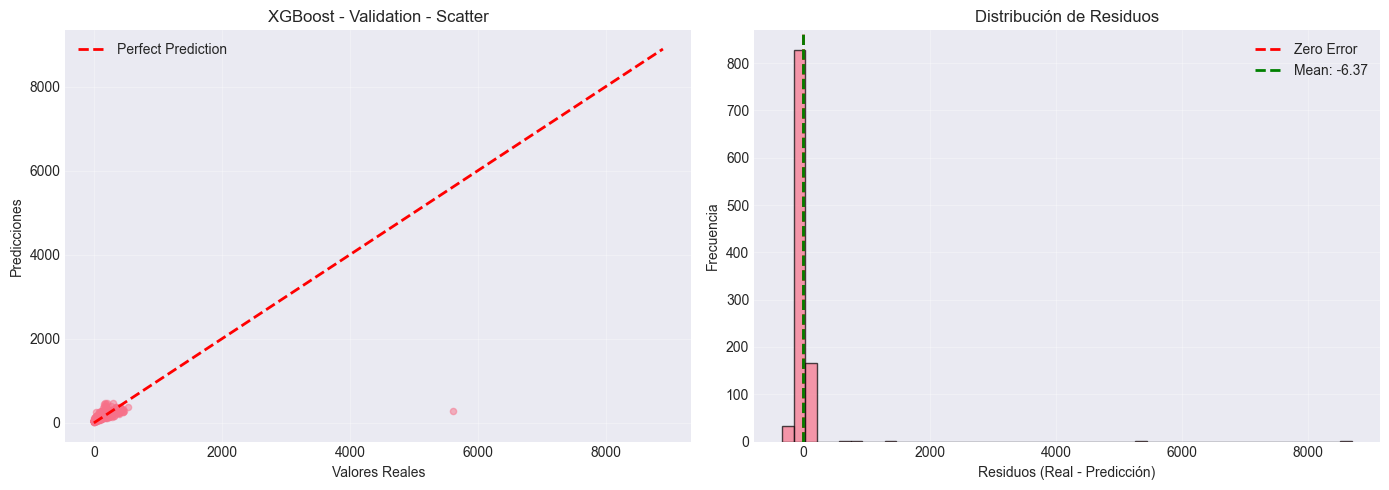

In [71]:
plot_predictions(y_val, y_val_pred_xgb, "XGBoost - Validation")


# 9. OPTIMIZACIÓN DE HIPERPARÁMETROS CON GRIDSEARCHCV

Ahora que tenemos los modelos baseline, vamos a optimizar los hiperparámetros usando **GridSearchCV** y **MLflow** para trackear todos los experimentos.

**Beneficios:**
- Probar múltiples combinaciones de hiperparámetros automáticamente
- MLflow registra CADA combinación probada
- Selección automática del mejor modelo
- Validación cruzada para robustez


## 9.1 GridSearchCV para Random Forest

Empezamos con Random Forest ya que mostró el mejor rendimiento baseline.


In [72]:
from sklearn.model_selection import GridSearchCV
import time

print("="*70)
print("GRIDSEARCHCV - RANDOM FOREST")
print("="*70)

# Grid de hiperparámetros a probar (ANTI-OVERFITTING)
# Con 71 features, exploramos opciones más conservadoras
rf_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],          # Profundidades limitadas
    'min_samples_split': [10, 15, 20],  # Splits conservadores
    'min_samples_leaf': [5, 10],        # Hojas más gruesas
    'max_features': [0.3, 0.4, 'sqrt']  # Menos features por árbol
}

print(f"\n📊 Configuración GridSearch:")
print(f"  Total combinaciones: {np.prod([len(v) for v in rf_param_grid.values()])}")
print(f"  CV folds: 3")
print(f"  Scoring: neg_mean_squared_error")
print(f"\nEsto tomará varios minutos...")

# GridSearchCV con cross-validation
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Entrenar con tracking de tiempo
start_time = time.time()

with mlflow.start_run(run_name="rf_gridsearch") as run:
    print("\n🔄 Iniciando GridSearchCV...")
    rf_grid.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    
    # Log del experimento principal
    mlflow.log_param("model_type", "Random Forest GridSearchCV")
    mlflow.log_param("total_combinations", len(rf_grid.cv_results_['params']))
    mlflow.log_param("cv_folds", 3)
    mlflow.log_param("training_time_seconds", training_time)
    
    # Mejores parámetros
    best_params = rf_grid.best_params_
    best_score = -rf_grid.best_score_  # Negativo porque era neg_mse
    
    print(f"\n✅ GridSearch completado en {training_time:.2f} segundos")
    print(f"\n🏆 MEJORES HIPERPARÁMETROS:")
    for param, value in best_params.items():
        print(f"  • {param}: {value}")
        mlflow.log_param(f"best_{param}", value)
    
    print(f"\n📊 Mejor RMSE (CV): {np.sqrt(best_score):.2f}")
    mlflow.log_metric("best_cv_rmse", np.sqrt(best_score))
    
    # Evaluar en validation
    best_rf = rf_grid.best_estimator_
    y_val_pred_grid = best_rf.predict(X_val)
    y_test_pred_grid = best_rf.predict(X_test)
    
    val_metrics_grid = evaluate_model(y_val, y_val_pred_grid, "Validation")
    test_metrics_grid = evaluate_model(y_test, y_test_pred_grid, "Test")
    
    # Log métricas
    for metric_name, value in val_metrics_grid.items():
        mlflow.log_metric(f"val_{metric_name}", value)
    for metric_name, value in test_metrics_grid.items():
        mlflow.log_metric(f"test_{metric_name}", value)
    
    # Guardar modelo
    mlflow.sklearn.log_model(best_rf, "model", 
                              registered_model_name="bike-demand-rf-optimized")
    
    # Feature importance
    feature_importance_grid = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    importance_path = MODELS_DIR / 'rf_gridsearch_feature_importance.csv'
    feature_importance_grid.to_csv(importance_path, index=False)
    mlflow.log_artifact(str(importance_path))
    
    print(f"\n✓ Run ID: {run.info.run_id}")

# Mostrar resultados
print("\n" + "="*70)
print("RESULTADOS DEL MEJOR MODELO (GridSearchCV)")
print("="*70)
print_metrics(val_metrics_grid, "Validation")
print_metrics(test_metrics_grid, "Test")

# Comparación con baseline
print("\n" + "="*70)
print("COMPARACIÓN: BASELINE vs GRIDSEARCH")
print("="*70)
print(f"{'Métrica':<20} {'Baseline':<15} {'GridSearch':<15} {'Mejora'}")
print("-"*70)
print(f"{'Val MAE':<20} {val_metrics_rf['mae']:>10.2f}     {val_metrics_grid['mae']:>10.2f}     {((val_metrics_rf['mae']-val_metrics_grid['mae'])/val_metrics_rf['mae']*100):>6.1f}%")
print(f"{'Val RMSE':<20} {val_metrics_rf['rmse']:>10.2f}     {val_metrics_grid['rmse']:>10.2f}     {((val_metrics_rf['rmse']-val_metrics_grid['rmse'])/val_metrics_rf['rmse']*100):>6.1f}%")
print(f"{'Val R²':<20} {val_metrics_rf['r2']:>10.4f}     {val_metrics_grid['r2']:>10.4f}     {((val_metrics_grid['r2']-val_metrics_rf['r2'])/val_metrics_rf['r2']*100):>6.1f}%")
print("="*70)


GRIDSEARCHCV - RANDOM FOREST

📊 Configuración GridSearch:
  Total combinaciones: 162
  CV folds: 3
  Scoring: neg_mean_squared_error

Esto tomará varios minutos...

🔄 Iniciando GridSearchCV...
Fitting 3 folds for each of 162 candidates, totalling 486 fits

✅ GridSearch completado en 118.76 segundos

🏆 MEJORES HIPERPARÁMETROS:
  • max_depth: 20
  • max_features: sqrt
  • min_samples_leaf: 10
  • min_samples_split: 10
  • n_estimators: 150

📊 Mejor RMSE (CV): 268.34


2025/10/11 18:31:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/11 18:32:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'bike-demand-rf-optimized' already exists. Creating a new version of this model...
Created version '2' of model 'bike-demand-rf-optimized'.



✓ Run ID: da3d06b4ca8842118bc32c2a25f4e0ab

RESULTADOS DEL MEJOR MODELO (GridSearchCV)

MÉTRICAS - VALIDATION
MAE:     57.67  ✗  (target: < 50)
RMSE:   327.32  ✗  (target: < 80)
R²:     0.1033  ✗  (target: > 0.7)
MAPE:   137.96% ✗  (target: < 25%)

Residuos:
  Mean:    -3.51  (debe estar ~0)
  Std:    327.30

MÉTRICAS - TEST
MAE:    101.80  ✗  (target: < 50)
RMSE:   314.79  ✗  (target: < 80)
R²:     0.1977  ✗  (target: > 0.7)
MAPE:    66.18% ✗  (target: < 25%)

Residuos:
  Mean:    86.09  (debe estar ~0)
  Std:    302.79

COMPARACIÓN: BASELINE vs GRIDSEARCH
Métrica              Baseline        GridSearch      Mejora
----------------------------------------------------------------------
Val MAE                   58.79          57.67        1.9%
Val RMSE                 326.44         327.32       -0.3%
Val R²                   0.1082         0.1033       -4.5%


## 9.2 Feature Importance del Modelo Optimizado


TOP 20 FEATURES - RANDOM FOREST OPTIMIZADO
              feature  importance
hr_weekday_avg_demand    0.156212
        hr_q75_demand    0.061651
        hr_avg_demand    0.058847
     hr_median_demand    0.047664
            hr_season    0.047368
                   hr    0.043957
      thermal_comfort    0.031715
   temp_roll_mean_24h    0.024484
           wind_chill    0.023941
        hr_std_demand    0.022778
         is_peak_hour    0.022446
                 temp    0.022057
    temp_roll_mean_3h    0.021494
        hr_weathersit    0.020834
               hr_sin    0.020659
    is_commute_window    0.020192
            hr_x_mnth    0.018967
          temp_season    0.018836
        hr_workingday    0.017426
         week_of_year    0.017130


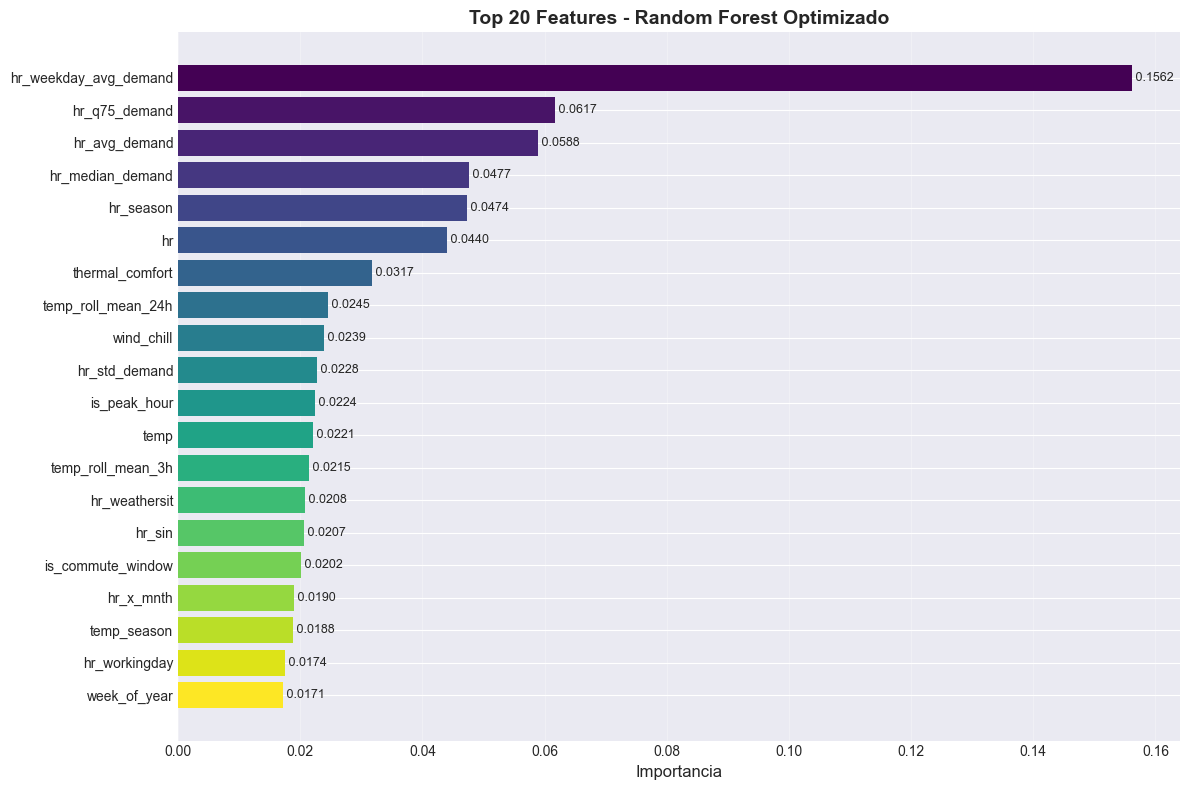


💡 Insights:
  • Top 3 features explican ~27.7% de la importancia
  • Feature más importante: hr_weekday_avg_demand (0.1562)


In [73]:
# Mostrar top 20 features más importantes
print("="*70)
print("TOP 20 FEATURES - RANDOM FOREST OPTIMIZADO")
print("="*70)
print(feature_importance_grid.head(20).to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(12, 8))
top_features = feature_importance_grid.head(20)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
ax.barh(range(len(top_features)), top_features['importance'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importancia', fontsize=12)
ax.set_title('Top 20 Features - Random Forest Optimizado', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Agregar valores en las barras
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['importance'], i, f' {row["importance"]:.4f}', 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n💡 Insights:")
print(f"  • Top 3 features explican ~{top_features.head(3)['importance'].sum()*100:.1f}% de la importancia")
print(f"  • Feature más importante: {top_features.iloc[0]['feature']} ({top_features.iloc[0]['importance']:.4f})")


# 8. COMPARACIÓN DE MODELOS

Comparamos los 3 modelos baseline para seleccionar el mejor.


In [74]:
# Crear tabla comparativa
comparison_df = pd.DataFrame([
    {
        'Model': 'Ridge Regression',
        'Train_MAE': train_metrics_ridge['mae'],
        'Val_MAE': val_metrics_ridge['mae'],
        'Test_MAE': test_metrics_ridge['mae'],
        'Train_RMSE': train_metrics_ridge['rmse'],
        'Val_RMSE': val_metrics_ridge['rmse'],
        'Test_RMSE': test_metrics_ridge['rmse'],
        'Train_R2': train_metrics_ridge['r2'],
        'Val_R2': val_metrics_ridge['r2'],
        'Test_R2': test_metrics_ridge['r2'],
        'Val_MAPE': val_metrics_ridge['mape']
    },
    {
        'Model': 'Random Forest',
        'Train_MAE': train_metrics_rf['mae'],
        'Val_MAE': val_metrics_rf['mae'],
        'Test_MAE': test_metrics_rf['mae'],
        'Train_RMSE': train_metrics_rf['rmse'],
        'Val_RMSE': val_metrics_rf['rmse'],
        'Test_RMSE': test_metrics_rf['rmse'],
        'Train_R2': train_metrics_rf['r2'],
        'Val_R2': val_metrics_rf['r2'],
        'Test_R2': test_metrics_rf['r2'],
        'Val_MAPE': val_metrics_rf['mape']
    },
    {
        'Model': 'XGBoost',
        'Train_MAE': train_metrics_xgb['mae'],
        'Val_MAE': val_metrics_xgb['mae'],
        'Test_MAE': test_metrics_xgb['mae'],
        'Train_RMSE': train_metrics_xgb['rmse'],
        'Val_RMSE': val_metrics_xgb['rmse'],
        'Test_RMSE': test_metrics_xgb['rmse'],
        'Train_R2': train_metrics_xgb['r2'],
        'Val_R2': val_metrics_xgb['r2'],
        'Test_R2': test_metrics_xgb['r2'],
        'Val_MAPE': val_metrics_xgb['mape']
    }
])

print("="*100)
print("COMPARACIÓN DE MODELOS BASELINE")
print("="*100)
print(comparison_df.to_string(index=False))

# Identificar mejor modelo por validation
best_idx = comparison_df['Val_RMSE'].idxmin()
best_model = comparison_df.iloc[best_idx]['Model']

print(f"\n{'='*100}")
print(f"🏆 MEJOR MODELO: {best_model}")
print(f"{'='*100}")
print(f"  Validation MAE:  {comparison_df.iloc[best_idx]['Val_MAE']:.2f}  (target: < {TARGET_METRICS['MAE']})")
print(f"  Validation RMSE: {comparison_df.iloc[best_idx]['Val_RMSE']:.2f}  (target: < {TARGET_METRICS['RMSE']})")
print(f"  Validation R²:   {comparison_df.iloc[best_idx]['Val_R2']:.4f}  (target: > {TARGET_METRICS['R2']})")
print(f"  Validation MAPE: {comparison_df.iloc[best_idx]['Val_MAPE']:.2f}%  (target: < {TARGET_METRICS['MAPE']}%)")

# Guardar comparación
comparison_path = MODELS_DIR / 'model_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"\n✓ Comparación guardada en: {comparison_path}")


COMPARACIÓN DE MODELOS BASELINE
           Model  Train_MAE    Val_MAE   Test_MAE  Train_RMSE   Val_RMSE  Test_RMSE  Train_R2   Val_R2  Test_R2   Val_MAPE
Ridge Regression  71.998125 100.954782 119.315079  265.372948 340.071704 325.145735  0.160672 0.032089 0.144030 362.583890
   Random Forest  33.495097  58.792019 100.106080  227.248497 326.435704 313.294432  0.384511 0.108154 0.205292 136.911378
         XGBoost  57.291580  67.256955 115.185692  239.731399 329.418617 323.486183  0.315035 0.091781 0.152746 232.963872

🏆 MEJOR MODELO: Random Forest
  Validation MAE:  58.79  (target: < 50)
  Validation RMSE: 326.44  (target: < 80)
  Validation R²:   0.1082  (target: > 0.7)
  Validation MAPE: 136.91%  (target: < 25%)

✓ Comparación guardada en: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\models\model_comparison.csv


# 9. RESUMEN Y PRÓXIMOS PASOS

---

## ✅ Modelos Entrenados

1. **Ridge Regression** - Baseline lineal simple
2. **Random Forest** - Ensemble de árboles
3. **XGBoost** - Gradient boosting (modelo principal)

## 📊 Métricas Objetivo

| Métrica | Target | Descripción |
|---------|--------|-------------|
| MAE | < 50 | Error absoluto medio |
| RMSE | < 80 | Error cuadrático medio |
| R² | > 0.7 | Coeficiente de determinación |
| MAPE | < 25% | Error porcentual medio |

## 🚀 Próximos Pasos

1. **Análisis de errores por segmentos** (hora, clima, season)
2. **Hyperparameter tuning** del mejor modelo
3. **Feature selection** basado en importance
4. **Ensemble de modelos** (stacking/blending)
5. **Evaluación exhaustiva** con test set
6. **Deployment** del modelo final

## 📝 Archivos Generados

- `models/rf_feature_importance.csv`
- `models/xgb_feature_importance.csv`
- `models/model_comparison.csv`
- MLflow runs en `mlruns/`

## 🔗 MLflow UI

Para visualizar experimentos:
```bash
mlflow ui
```

Abrir: http://localhost:5000

---

**Notebook completado:** `02_modeling.ipynb`  
**Estado:** ✅ Modelos baseline entrenados  
**Siguiente:** Optimización y evaluación exhaustiva
